# Neural Learning

Last revision: Wed  6 Apr 2022 21:09:00 AEST

Author: Omar Ghattas

## Introduction

In this lab we will expand on some of the concepts of neural learning, starting with an extension of the perceptron to the linear unit, which can be trained using gradient descent. 

The remainder of the lab goes into some "hands-on" aspects of supervised learning for neural networks, based on the multi-layer perceptron trained by error back-propagation. 

This code is for explanatory purposes only – for real neural networks you would use one of the many code libraries that exist. 

### Acknowledgements:
Autograd Theory:

    1. https://people.cs.umass.edu/~domke/courses/sml2011/08autodiff_nnets.pdf
    2. Mathematics for Machine Learning by Marc Peter Deisenroth, A. Aldo Faisal, and Cheng Soon Ong.

Pytorch Neural Network Examples:

    1. https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
    
MLP Code from Scratch

    1. https://github.com/rcassani/mlp-example

#### Useful Functions
We will rely on the following helper functions which you can treat as a black box.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(n=20, means=[[3,3],[-1,1]], seed=1):
    '''
    generate data from two gaussians
    '''
    np.random.seed(seed)
    m1 = np.array(means[0])
    m2 = np.array(means[1])
    S1 = np.random.rand(2,2)
    S2 = np.random.rand(2,2)
    dist_01 = np.random.multivariate_normal(m1, S1.T @ S1, n)
    dist_02 = np.random.multivariate_normal(m2, S2.T @ S2, n)
    X = np.concatenate((np.ones(2*n).reshape(-1,1), 
                        np.concatenate((dist_01, dist_02))), axis=1)
    y = np.concatenate((np.ones(n), np.zeros(n))).reshape(-1,1)
    shuffle_idx = np.random.choice(2*n, size=2*n, replace=False)
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    return X, y

def plot_perceptron(ax, X, y, w):
    pos_points = X[np.where(y==1)[0]]
    neg_points = X[np.where(y==0)[0]]
    ax.scatter(pos_points[:, 1], pos_points[:, 2], color='blue')
    ax.scatter(neg_points[:, 1], neg_points[:, 2], color='red')
    xx = np.linspace(-6,6)
    yy = -w[0]/w[2] - w[1]/w[2] * xx
    ax.plot(xx, yy, color='orange')
    
    ratio = (w[2]/w[1] + w[1]/w[2])
    xpt = (-1*w[0] / w[2]) * 1/ratio
    ypt = (-1*w[0] / w[1]) * 1/ratio
    
    ax.arrow(xpt, ypt, w[1], w[2], head_width=0.2, color='orange')
    ax.axis('equal')

## Augmenting the Perceptron with Gradient Descent

Recall from that the Perceptron is a mistake-driven algorithm - it continues to update so long as it makes mistakes on the data. In the linearly separable setting, where can separate the data exactly with a linear separator, the algorithm is always guaranteed to terminate. If however the data is not linearly separable, the algorithm will never terminate. In this case, we might still want to learn a linear classifier that achieves low error (classifies most of the points correctly), and instead of looking at a mistake-driven algorithm, we look instead to a loss-based algorithm. In this section, we introduce learning linear classifiers via gradient descent. You should view this section of the lab as a precursor to learning in multilayer perceptrons (Neural Networks) via Backpropagation. This extension is known as the linear unit, it is basically a one-node neural network.

The original perceptron uses the sgn activation function, which we saw earlier has a 'S' shape. We can use a smoother version of the sgn activation known as a sigmoid. The reason we prefer smoother activations is that we can take derivatives (any function with sharp angles (discontinuities) is not differentiable). We use here a type of sigmoid known as the logistic sigmoid: 

$$
\sigma(x) = \frac{1}{1+e^{-x}}
$$

Now, note that

$$
\frac{d \sigma(x)}{d x} = \sigma(x) (1-\sigma(x))
$$

We can now implement the sigmoid and its derivative and observe its shape for different values of the steepness parameter:

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-1*x))

def grad_sigmoid(x):
    return sigmoid(x) * (1-sigmoid(x))

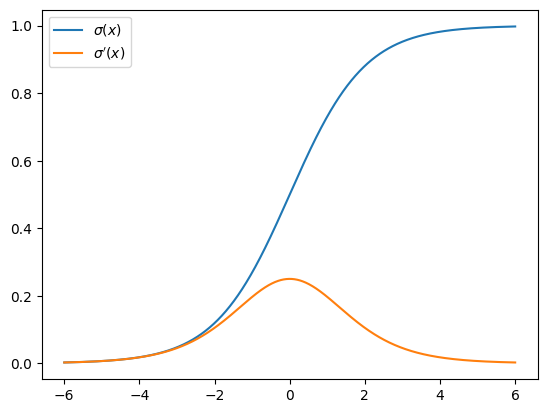

In [3]:
# plot sigmoid functions 
xx = np.linspace(-6, 6, 1000)
plt.plot(xx, sigmoid(xx), label='$\sigma(x)$')
plt.plot(xx, grad_sigmoid(xx), label='$\sigma\'(x)$')
plt.legend()
plt.show()

Instead of updating $w$ whenever we make a mistake, i.e. whenever $w^T x y < 0$, we will consider updating the weight vector by moving in a direction that minimizes the loss as much as possible, this is known as gradient descent/

Recall that the prediction (output) of the standard perceptron was $\hat{y}=\text{sgn}(h_w(x))$. Since we are no longer using the sign activation, but the sigmoid activation, our output now is $\hat{y} =  \sigma(h_w(x)) = \sigma(w^T x)$. Next, consider the cross-entropy loss

$$
L(w) = - \sum_{i=1}^N y_i \ln p_i + (1-y_i) \ln (1-p_i), \qquad p_i = \sigma(w^T x_i) = \frac{1}{1+e^{-w^T x_i}}.
$$

We would like to find $\hat{w}$ that minimizes this loss, i.e. we want to solve 

$$
\hat{w} = \arg \min_w L(w).
$$

Unfortunately in this case, we cannot solve for $\hat{w}$ in closed form, and so we must resort to numerical techniques such as gradient descent.

 <font color='purple'>

#### Exercise:
    
1. Show that $\frac{d p_i}{dw} = p_i (1-p_i) x_i$, where $p_i = \sigma(w^T x_i)$.
2. Show that $\frac{d \ln p_i}{dw} = (1-p_i) x_i$.
3. Using the results of the previous parts, show that $\frac{d L(w)}{dw} = - \sum_{i=1}^n (y_i - p_i) x_i$. Write down the gradient descent update for $w$ with step size $\eta$.
4. Fill out the code below to implement gradient descent for the model on a randomly generated dataset.

In [11]:
def loss_i(w, x_i, y_i):
    '''cross entropy loss for i-th data point'''
    p_i = sigmoid(w @ x_i)
    return - (y_i * np.log(p_i) + (1 - y_i) * np.log(1 - p_i))
    
def grad_loss_i(w, x_i, y_i):
    '''grad loss for i-th data point'''
    p_i = sigmoid(w @ x_i)
    return -((y_i - p_i) * x_i)

def gradient_descent(X, y, eta, T):
    N = X.shape[0]
    w = np.array([0,0,0]) # init w
    for t in range(T):
        loss = 0
        grad_loss = 0
        for i in range(N):
            loss += loss_i(w, X[i], y[i])
            grad_loss += grad_loss_i(w, X[i], y[i])
        print(f"loss = {loss}")
        w = w - eta * grad_loss
        fig, ax = plt.subplots()
        plot_perceptron(ax, X, y, w)
        plt.show()

loss = [55.45177444]


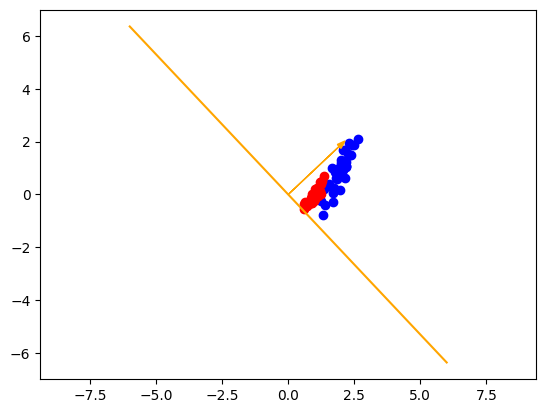

loss = [82.23337408]


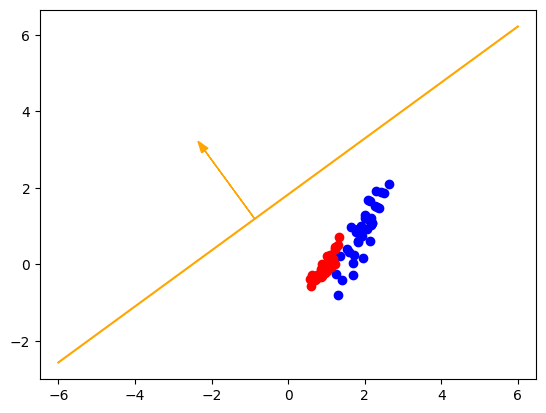

loss = [170.1009187]


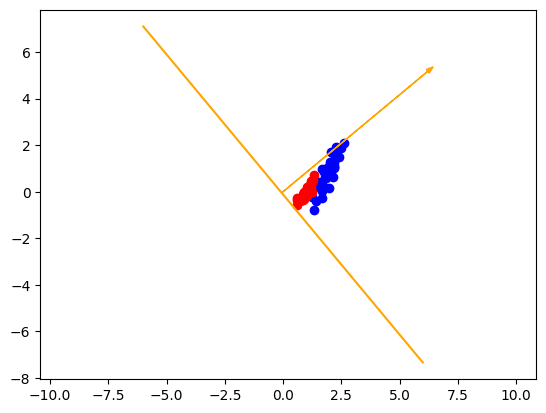

loss = [266.15160025]


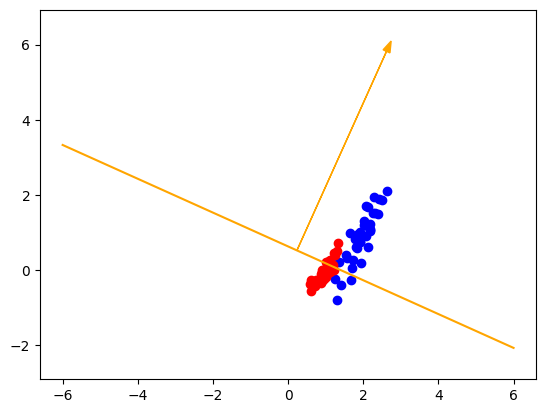

loss = [33.87424748]


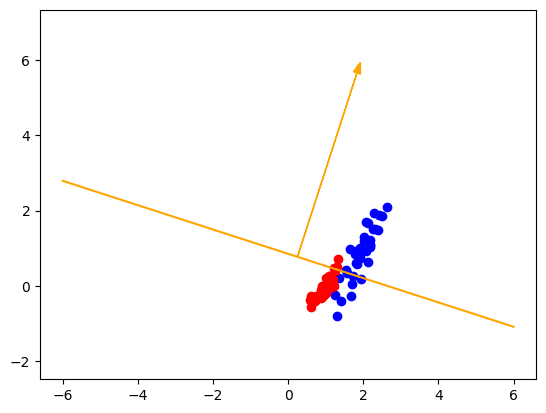

loss = [29.89696311]


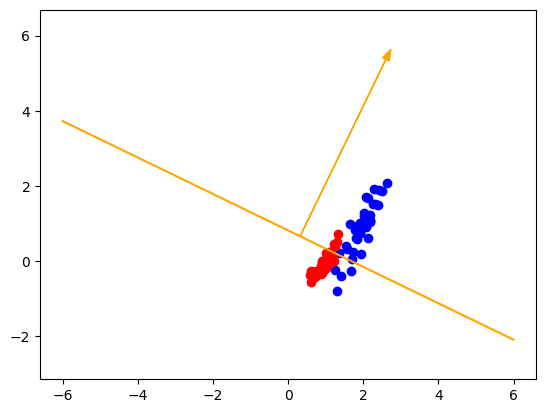

loss = [27.9431673]


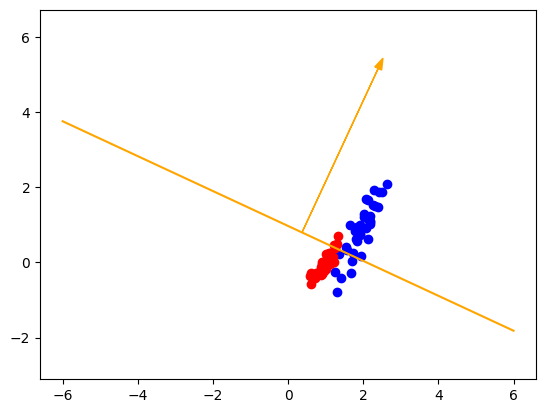

loss = [26.50966444]


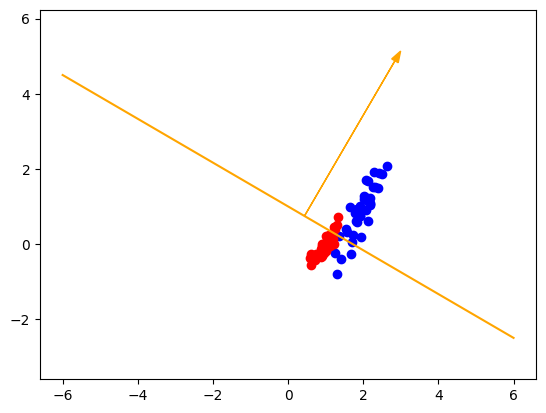

loss = [25.36239334]


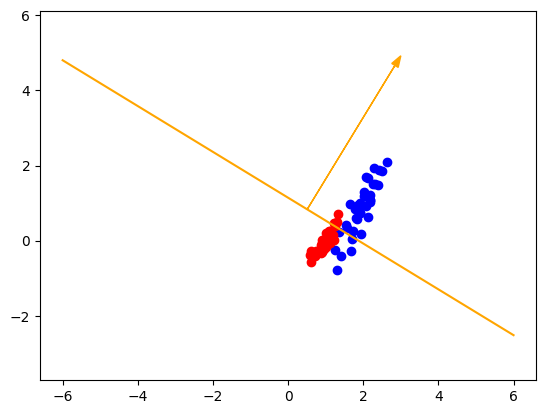

loss = [24.34035736]


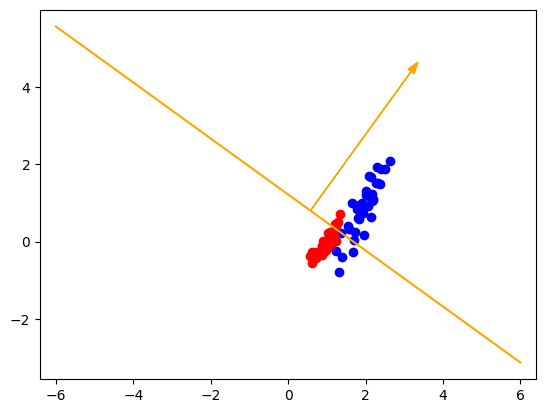

loss = [23.41360613]


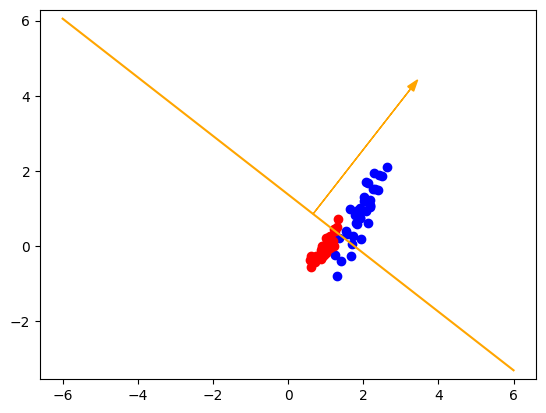

loss = [22.55720271]


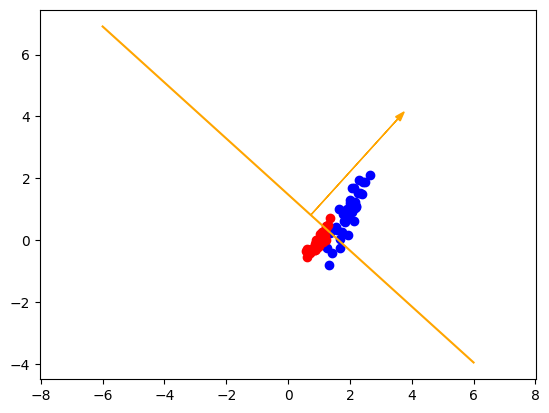

loss = [21.76595221]


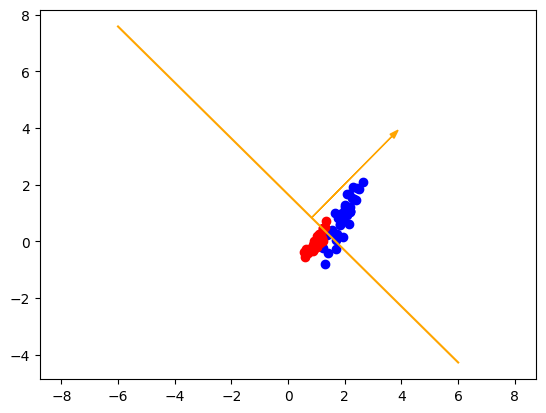

loss = [21.03226629]


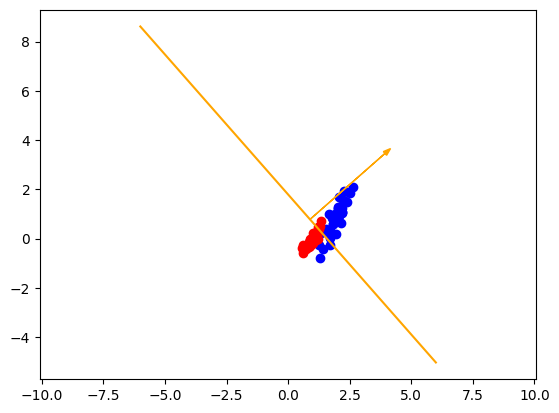

loss = [20.35381279]


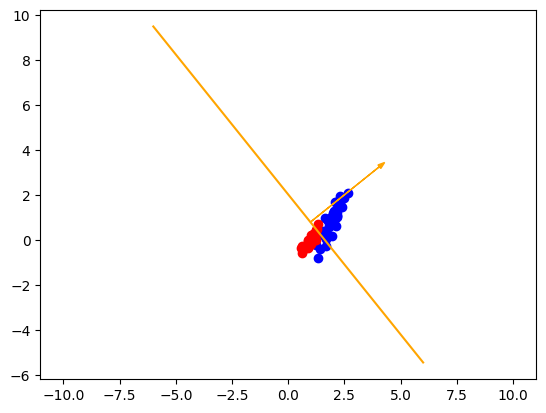

loss = [19.72553712]


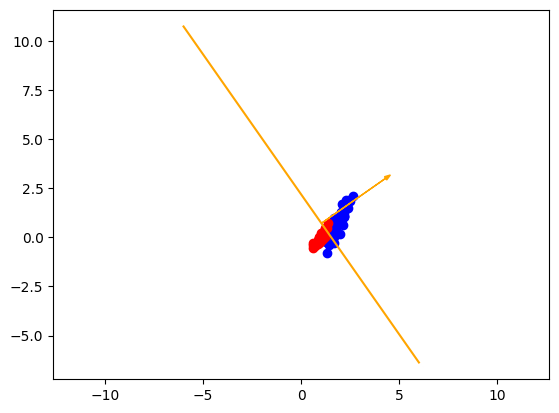

loss = [19.14550196]


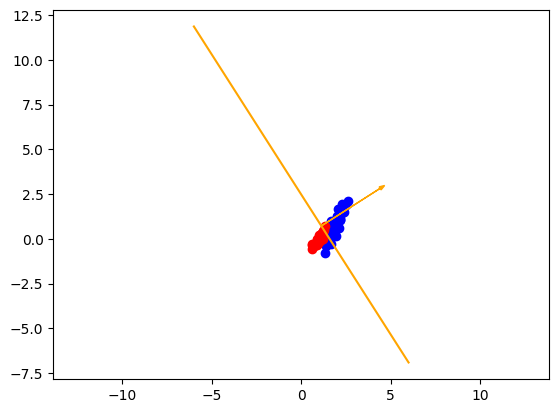

loss = [18.60882787]


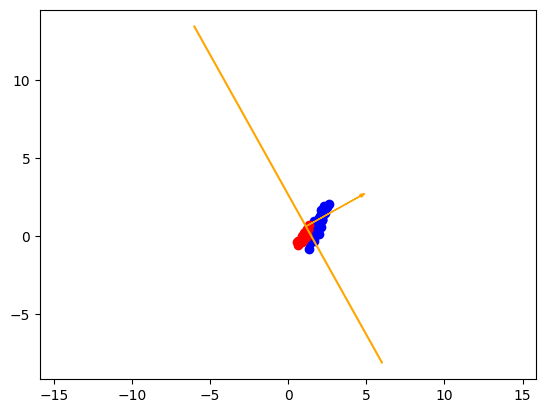

loss = [18.11458383]


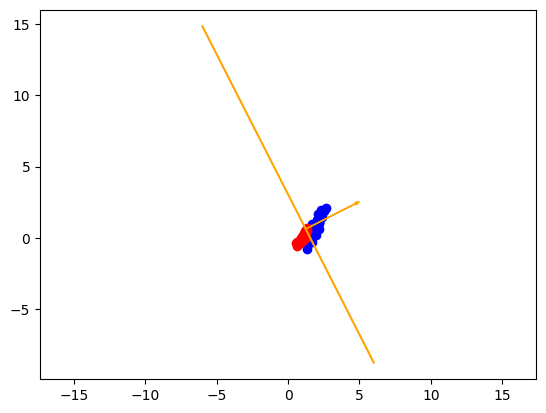

loss = [17.65744861]


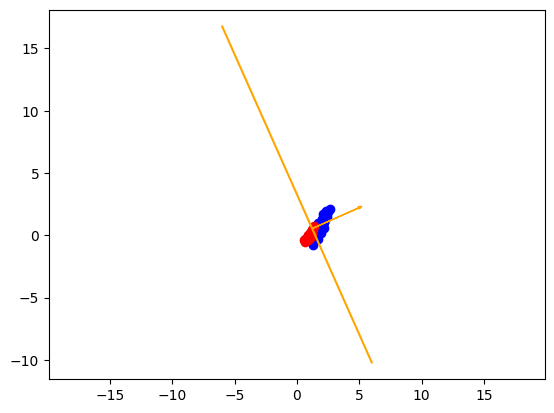

In [12]:
np.random.seed(12)
X, y = generate_data(n=40, means=[[2,1],[1,0]])
gradient_descent(X, y, 0.1, 20)

So far so good, we now have an algorithm that can give us something useful even when the data is not linearly separable. This is important since in practice we cannot hope to achieve zero error. One problem however is that in order to compute the gradient at each step, we need to run over the entire data set, which can be computationally infeasible. This brings us to the idea of Stochastic Gradient Descent (SGD). The idea behind SGD is very simple, instead of computing the true gradient by summing over the entire dataset, we instead estimate the gradient by looking at the gradient on a single observation. In other words, we update the weight vector after each observation.

 <font color='purple'>

#### Exercise:
    
5. Instead of SGD, which might have high variance, try to implement a batch gradient descent, in which we consider a subset of size $m \ll n$ to estimate the gradient with. Plot your results after each update. How does this compare with the results from gradient descent?
6. Consider the case of Linear Regression from the first tutorial. In this case, the optimisation can be done in closed form (least squares solution). Use gradient descent instead to solve linear regression on a simulated dataset, does the gradient descent solution achieve the least squares solution?
7. Investigate other sigmoid functions and implement them: https://en.wikipedia.org/wiki/Sigmoid_function

## Neural Networks

At this point, you should be comfortable with the two concepts covered so far: 1. Perceptrons and 2. Gradient Descent. These are the two basic building blocks for neural networks, also referred to as Multi-layer percetrpons. The idea is to chain together perceptrons to be able to learn very complex decision surfaces (as opposed to just linear decision surfaces in the case of the standard perceptron). Once we chain perceptrons together however, how do we learn the weights? We do so via Backpropagation, which at its core is an algorithm that implements the chain rule from calculus. Recall that the chain rule comes up any time we have a composition of functions. For example, consider two functions $g_1(x) = e^x$ and $g_2(x)=x^2-3$, then we can compose these functions:

$$
(g_1 \circ g_2) (x) = g_1(g_2(x)) = e^{x^2 - 3}.
$$

We could also compose them in the reverse direction:

$$
(f_2 \circ g_1) (x) = g_2(g_1(x)) = e^{2x} - 3.
$$

If we have a third function, say $g_3(x) = \log (x)$, then we can create the following 3-fold composition:

$$
(g_1 \circ g_2 \circ g_3)(x) = g_1(g_2(g_3(x))) = g_1( (\log x)^2 - 3 ) = e^{(\log x)^2 - 3 }.
$$

A neural network is essentially one big composition of functions, let's see why. Assume we have a $D$ layer neural network, and assume that the $i$-th layer has $n_i$ many units (or perceptrons), which can be different from layer to layer. The $j$-th perceptron in layer $i$ can therefore be represented by its weight vector $w^{ij}$ and its bias term $b^{ij}$. Instead of keeping track of all these vectors, we combine all the weights in a single layer into a single weight matrix, $W_i$, where each row of the matrix corresponds to the weights of a perceptron. Similarly, we combine all bias terms into a single vector $b_i$ (See the diagram below). To see why this is a composition, we can write the forward step of a NN as follows:

\begin{align*}
f_0 &:= x\\
f_i &:= \sigma(W_{i-1} f_i + b_{i-1}) \quad i=1,\dots,K.
\end{align*}

In other words, we set the input $x$ to be output of the zero-th layer, and the output of the $i$-th layer is the element-wise sigmoid of the matrix product $W_{i-1} f_i + b_{i-1}$. What is this product? Recall from above that the product $W f$ returns a vector where each element is the dot product $\langle w_i, f\rangle$, where $w_i$ is the $i$-th row of $W$, i.e. the weights of the $i$-th perceptron/unit in the corresponding layer. Adding $b$ adds the bias, and the sigmoid is applied element-wise. This output then becomes the input of the next layer, and so on.



<img src="misc/nn.jpg">

Let's unroll this process and show explicitly why it is a composition of functions. Let $f_K$ denote the output of a $K$ layer NN, then

\begin{align*}
y 
&= f_K(x)\\
&= \sigma(W_{K-1} f_{K-1}(x) + b_{K-1})\\
&= \sigma(W_{K-1} \sigma(W_{K-2} f_{K-2}(x) + b_{K-2}) + b_{K-1})\\
& ~~~~ \vdots\\
&= \sigma(W_{K-1} \sigma(W_{K-2} (\cdots \sigma( W_{0} x + b_0) )+ \cdots + b_{K-2}) + b_{K-1}),
\end{align*}

which is equivalent to writing:

$$
y = (f_K \circ f_{K-1} \circ \dots \circ f_1)(x) = f_K(f_{K-1}(f_{K-2}(\dots(f_1(x)) \cdots)).
$$

Now that we have understood the forward pass of a neural network, we can turn our attention to learning the parameters of the network. In this case, we need to learn the weights and biases in every layer, and we can combine our parameters into a single set $\theta := \{W_0, b_0, W_1, b_1,\dots, W_{K-1}, b_{K-1}\}$. Let $\theta_i = \{W_i, b_i\}$. Assume that we have some loss function $\mathcal{L}$, say MSE. Then, to perform gradient descent, we need to compute gradients of the loss with respect to each of the parameters, and update as in the gradient descent discussion above. The gradeints can be computed using the chain rule:

\begin{align*}
\frac{\partial \mathcal{L}}{\partial \theta_{K-1}} &= \frac{\partial \mathcal{L}}{\partial f_{K}} \color{red}{\frac{\partial f_K}{\partial \theta_{K-1}}}\\
\frac{\partial \mathcal{L}}{\partial \theta_{K-2}} &= 
\frac{\partial \mathcal{L}}{\partial f_{K}} 
\color{blue}{\frac{\partial f_K}{\partial f_{K-1}}}
\color{red}{\frac{\partial f_{K-1}}{\partial \theta_{K-2}}}\\
\frac{\partial \mathcal{L}}{\partial \theta_{K-3}} &= 
\frac{\partial \mathcal{L}}{\partial f_{K}} 
\color{blue}{\frac{\partial f_K}{\partial f_{K-1}} \frac{\partial f_{K-1}}{\partial f_{K-2}} }
\color{red}{\frac{\partial f_{K-2}}{\partial \theta_{K-3}}}\\
&\vdots\\
\frac{\partial \mathcal{L}}{\partial \theta_{i}} &= 
\frac{\partial \mathcal{L}}{\partial f_{K}} 
\color{blue}{\frac{\partial f_K}{\partial f_{K-1}}  \cdots \frac{\partial f_{i+1}}{\partial f_{i+1}} }
\color{red}{\frac{\partial f_{i+1}}{\partial \theta_{i}}}\\
\end{align*}



The terms in blue are the partial derivatives of the output of a layer with respect to its inputs, and the terms in red are the partial derivatives of the output of a layer with respect to its parameters. We make the important observation that if we simply compute each of the gradients naively, then we are redoing the same computations over and over, since the same (blue) terms crop up in many of the calculations. The idea behind backpropagation is to do the chain rule but in a smarter way, so as to re-use the computations already done at a layer to solve for gradients in later layers. For a detiled look at backpropagation, please refer to the more detailed derivation here: https://www.youtube.com/watch?v=dVexyOg3HnQ&t=1s&ab_channel=OmarGhattas 

## Automatic Differentiation and a short intro to PyTorch

Before we move on to computation, let us explore the computational aspects of Automatic Differentiation. Backpropagation is one special case of automatic differentiation, and many deep learning libraries, such as PyTorch, are general use automatic differentiation libraries. We saw earlier that standard chain rule can be computationally naive, and in fact is infeasible for compositions of a large number of functions, which is important if we want to do anything with deep networks! Let us consider a simplified example to demonstrate the power of autodiff.

Consider the following function:

$$
f(x) = \exp (\exp(x) + \exp(2x)) + \sin(\exp(x) + \exp(2x)).
$$

This looks quite complicated, but with a bit of work we can show that the derivative of $f$ is

$$
f'(x) = \exp (\exp(x) + \exp(2x))(\exp(x) + 2\exp(2x)) + \cos(\exp(x) + \exp(2x))(\exp(x) + 2\exp(2x))
$$

For those of you that attempted this by hand, you should see that the standard differentiation approach is somewhat wasteful, since we have the same factor $(\exp(x) + \exp(2x))$ in both expressions. Let's consider a more algorithmic approach. Define the following intermediate variables:

\begin{align*}
a &= \exp(x)\\
b &= a^2\\
c &= a+b\\
d &= \exp(c)\\
e &= \sin(c)\\
f &= d+e
\end{align*}

This may look strange at first, but we are basically rewriting $f(x)$ as an iterative procedure. We can represent this in graph form, using a structure known as a computational graph:

<img src="misc/f1.jpg">

The square nodes are computation nodes, they implement the functions they are named after, and the circular nodes are variable nodes, which store the intermediate variables. Viewing $g$ in this way allows us to compute the gradient in an iterative manner. We compute the derivatives of the intermediate variables with respect to their inputs:
\begin{align*}
\frac{\partial a}{\partial x} &= \exp(x)\\
\frac{\partial b}{\partial a} &= 2 a\\
\frac{\partial c}{\partial a} &= 1 = \frac{\partial c}{\partial b}\\
\frac{\partial d}{\partial c} &= \exp(c)\\
\frac{\partial e}{\partial c} &= \cos(c)\\
\frac{\partial f}{\partial d} &= 1 = \frac{\partial f}{\partial e}
\end{align*}

The goal is to compute $\frac{\partial g}{\partial x}$, we can do so by working our way backwards through the computation graph from the output node (node $f$) to the input node (node $x$). We first introduce the following notation $\text{child}(y)$ to denote the children of a node $y$. For example $\text{child}(c) = \{d, e\}$. Then, for any node $y$ in the graph, the chain rule tells us that

$$
\frac{\partial f}{\partial y} = \sum_{z \in \text{child}(y)} \frac{\partial f}{\partial z} \frac{\partial z}{\partial y}
$$

Let's apply this formula, we already have the partial derivatives of $f$ with respect to $d,e$ from above, so we start with $c$:

\begin{align*}
\frac{\partial f}{\partial c} &= \frac{\partial f}{\partial d}\frac{\partial d}{\partial c} + \frac{\partial f}{\partial e}\frac{\partial e}{\partial c} = 1 \times \exp(c) + 1 \times \cos (c)\\
\frac{\partial f}{\partial b} &= \frac{\partial f}{\partial c}\frac{\partial c}{\partial b} =\frac{\partial f}{\partial c} \times 1\\
\frac{\partial f}{\partial a} &= \frac{\partial f}{\partial b}\frac{\partial b}{\partial a} + \frac{\partial f}{\partial b}\frac{\partial b}{\partial a} = 
\frac{\partial f}{\partial b} \times 2 a + \frac{\partial f}{\partial c} \times 1\\
\frac{\partial f}{\partial x} &= \frac{\partial f}{\partial a} \frac{\partial a}{\partial x} = \frac{\partial f}{\partial a} \times \exp(x)
\end{align*}


Observe that the computation required for calculating the derivative is proportional to the computation required to calculate the function. You can visualise this process as if each node in the computational graph stores the derivatives of itself with respect to any child nodes, then to compute the gradient of the graph, we start from the output and work our way backwards, at each step re-using gradients computed earlier in the process. As you become more familiar with backpropagation, you should see that the two concepts are identical. Let's finalise our understanding by looking at a toy example using Pytorch. 

Since we have an excplicit form for the gradient, the goal will be to compare our explicit form to the solution computed numerically with PyTorch. Note that this is numerical differentiation, not symbolic, so the value of the gradient will change as we vary the input. We will compare the two results at the end.

In [14]:
import torch            # run "! pip3 install torch" in jupyter if you do not have torch

def func(x):
    t = np.exp(x) + np.exp(2*x)
    return np.exp(t) + np.sin(t)

def grad_func(x):
    t1 = np.exp(x) + np.exp(2*x)
    t2 = np.exp(x) + 2*np.exp(2*x)
    return t2 * (np.exp(t1) + np.cos(t1))

def sequential_func(x):
    inp = torch.tensor([[x]], dtype=torch.float64, requires_grad=True)
    a = torch.exp(inp)
    b = torch.pow(a, 2)
    c = a + b
    d = torch.exp(c)
    e = torch.sin(c)
    f = d + e
    f.backward()
    return inp.grad.item()

In [15]:
x_input = 0.2
print("explicit gradient: ", grad_func(x_input))
print("autograd gradient: ", sequential_func(x_input))

explicit gradient:  59.578079470554506
autograd gradient:  59.57807947055451


 <font color='purple'>

#### Exercise:
    
8. Consider the function $f(x) = \sqrt{x^2 + \exp(x^2)} + \cos(x^2 + \exp(x^2))$. Compute its derivative explicitly, and then write down its computational graph, repeat the analysis and use PyTorch to check your solutions.
9. We have just scratched the surface of numerical optimisation with PyTorch, try to re-implement the gradient descent perceptron, note that we no longer need to explicitly compute the gradient, we can just rely on automatic differentiation.
10. Repeat 2. but for Linear Regression, or any other loss-based model.

To finish of the lab, we will see how to use pytorch to train a neural network on the MNIST dataset, and then we will look at some code that implements a neural network from scratch. In practice, we will obviously make use of existing libraries like pytorch, but it is also important to be able to build things from scratch.

#### MNIST Dataset
First we load in the MNIST dataset using the pytorch utilities. We transform the data and create a loader object that makes training networks more straight forward. We can set the batch size directly in the loader object, and this is analogous to the discussion on batch gradient descent earlier.

In [16]:
import torchvision           #! pip3 install torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
trainset = MNIST(root = './', train=True, download=True, transform=transform)
testset = MNIST(root = './', train=False, download=True, transform=transform)

31.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

92.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
batch_size = 5
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size, 
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size, 
                                         shuffle=False)
classes = (0,1,2,3,4,5,6,7,8,9)

Pytorch makes it very simple to define networks, you need to create a Net() class that inherits from the nn module. You then need to define your architecture in the __init__ method, and a forward pass of your network. In this case, we are constructing a very simple neural network with a single hidden layer. We are dealing with MNIST, which are $28 \times 28$ arrays (images), and so we have $28 \times 28 = 784$ features. Therefore, the first layer (fully connected layer fc1) needs to have input dimension equal to 784. The output dimension can be anything, and I chose 100 arbitrarily. The second fully connected layer needs to have the same input dimension as the previous output dimension. Finally, since we have 10 classes, the output dimension of the last fully connected layer, in this case fc2, must be 10.

The forward function describes what we want the network to do, and we are simply implementing the function 

$$
y = f_2(f_1(x)),
$$

where $f_i(x) = \sigma(W_{i-1}x+b_{i-1})$, and where we have chosen the ReLU activation, $\sigma(x) = \max\{0,x\}$, one of the most popular choices in the current literature. 

Next, we define a loss function (criterion), in this case we use the CrossEntropy Loss, which is appropriate for multi-class classification, and finally we define an optimizer, in this case we just use stochastic gradient descent. The rest of the code explains how to call the loader object to get some data, compute the network output, compute the gradients, and then update the weights.

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 10) 

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(5):  
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.873
[1,  4000] loss: 0.419
[1,  6000] loss: 0.368
[1,  8000] loss: 0.324
[1, 10000] loss: 0.306
[1, 12000] loss: 0.267
[2,  2000] loss: 0.280
[2,  4000] loss: 0.257
[2,  6000] loss: 0.225
[2,  8000] loss: 0.207
[2, 10000] loss: 0.205
[2, 12000] loss: 0.194
[3,  2000] loss: 0.179


KeyboardInterrupt: 

Now that we have trained our network, let's check out its test accuracy:

In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 94 %


As many of you know, it is more appropriate to use convolutional neural networks for image data, and the following shows it is fairly straightforward to extend the above to the CNN setting. For those interested, you can read more here: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

In [20]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 60)
        self.fc2 = nn.Linear(60, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

net = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.561
[1,  4000] loss: 0.603
[1,  6000] loss: 0.443
[1,  8000] loss: 0.369
[1, 10000] loss: 0.308
[1, 12000] loss: 0.286
[2,  2000] loss: 0.253
[2,  4000] loss: 0.258
[2,  6000] loss: 0.242
[2,  8000] loss: 0.222
[2, 10000] loss: 0.220
[2, 12000] loss: 0.214
[3,  2000] loss: 0.180
[3,  4000] loss: 0.202
[3,  6000] loss: 0.189
[3,  8000] loss: 0.184
[3, 10000] loss: 0.179


KeyboardInterrupt: 

In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 95 %


We see that the CNN achieves performance similar to the standard NN, and this is almost definitely due to requiring more training. The code in this section has been instructional, and you should try to tweak the parameters/network architectures to get better results.

### Advanced Exercise
Find a recent paper (NeuRIPS, ICML, ICLR, etc..) that introduces a novel deep learning architecture and implement it in pytorch

### MLP from scratch
Finally, we will now take a look at a MLP code example built from scratch. We will no longer rely on pytorch to build models (although we will use the same mnist data installed from torch).

In [22]:
from sklearn.preprocessing import OneHotEncoder

# we will work with a small random subset of 10000 images
np.random.seed(123)
idxs = np.random.choice(range(60000), size=10000)

Xtrain = trainset.data.numpy()[idxs]
Xtrain = Xtrain.reshape(Xtrain.shape[0], -1)
ytrain = trainset.targets.numpy()[idxs]
labels = np.unique(ytrain)

# one hot encoded version of y, called Y
Ytrain = OneHotEncoder(sparse=False).fit_transform(ytrain.reshape(-1,1))

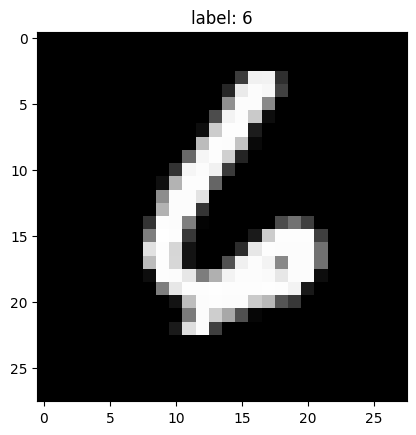

In [23]:
# for example, we can look at an image of one of the MNIST figures by doing:
ii = 23
plt.imshow(Xtrain[ii].reshape(28,28), cmap="gray")
plt.title(f"label: {ytrain[ii]}")
plt.show()

## Implementing a Multi-layer Perceptron from Scratch

In [ ]:
class Mlp():
    # reference: Based on the Mlp example code by Raymundo Cassani
    # https://github.com/rcassani/mlp-example
    def __init__(self, size_layers):
        '''
        Arguments:
            size_layers : List with the number of Units for:
                [Input, Hidden1, Hidden2, ... HiddenN, Output] Layers.
        '''
        self.size_layers = size_layers
        self.n_layers    = len(size_layers)
 
        # initialize weights (in a smart way)
        self.initialize_weights()

    def train(self, X, Y, iterations=100):
        '''
        Given X (feature matrix) and y (class vector)
        Updates the Weights by running Backpropagation N tines
        Arguments:
            X          : Feature matrix [n_examples, n_features]
            Y          : Sparse class matrix [n_examples, classes]
            iterations : Number of times Backpropagation is performed
                default = 100
        '''
        n_examples = Y.shape[0]

        for iteration in range(iterations):
            self.gradients = self.backpropagation(X, Y)
            self.gradients_vector = self.unroll_weights(self.gradients)
            self.weight_vector = self.unroll_weights(self.weights)
            self.weight_vector = self.weight_vector - self.gradients_vector
            self.weights = self.roll_weights(self.weight_vector)

    def predict(self, X):
        '''
        Given X (feature matrix), y_hat is computed
        Arguments:
            X      : Feature matrix [n_examples, n_features]
        Output:
            y_hat  : Computed Vector Class for X
        '''
        A , Z = self.feedforward(X)
        Y_hat = A[-1]
        return Y_hat
    
    def initialize_weights(self):
        '''
        Initialize weights - initialization method depends
        on the Number of Units in the current layer
        and the next layer. The weights for each layer as of the 
        size [next_layer, current_layer + 1]
        '''
        self.weights = []
        size_next_layers = self.size_layers.copy()
        size_next_layers.pop(0)
        for size_layer, size_next_layer in zip(self.size_layers, size_next_layers):
            # Method presented "Understanding the difficulty of training deep feedforward neural networks"
            # Xavier Glorot and Youshua Bengio, 2010
            epsilon = 4.0 * np.sqrt(6) / np.sqrt(size_layer + size_next_layer)
            # Weigts from a uniform distribution [-epsilon, epsion] 
            tmp = epsilon * ( (np.random.rand(size_next_layer, size_layer + 1) * 2.0 ) - 1)
            self.weights.append(tmp)
        return self.weights

    def backpropagation(self, X, Y):

        g_dz = lambda x: self.sigmoid_derivative(x)
        n_examples = X.shape[0]
        
        # Feedforward
        A, Z = self.feedforward(X)

        # Backpropagation
        deltas = [None] * self.n_layers
        deltas[-1] = A[-1] - Y
        # For the second last layer to the second one
        for ix_layer in np.arange(self.n_layers - 1 - 1 , 0 , -1):
            tmp = self.weights[ix_layer]
            tmp = np.delete(tmp, np.s_[0], 1)
            deltas[ix_layer] = (tmp.T @ deltas[ix_layer + 1].T ).T * g_dz(Z[ix_layer])

        # Compute gradients
        gradients = [None] * (self.n_layers - 1)
        for ix_layer in range(self.n_layers - 1):
            grads_tmp = deltas[ix_layer + 1].T @ A[ix_layer]
            gradients[ix_layer] = grads_tmp / n_examples 
        return gradients

    def feedforward(self, X):

        g = lambda x: self.sigmoid(x)
        A = [None] * self.n_layers
        Z = [None] * self.n_layers
        input_layer = X

        for ix_layer in range(self.n_layers - 1):
            n_examples = input_layer.shape[0]
            # augment input layer with vector of ones to account for bias
            input_layer = np.concatenate((np.ones([n_examples, 1]), input_layer), axis=1)
            A[ix_layer] = input_layer
            # Multiplying input_layer by weights for this layer
            Z[ix_layer + 1] = input_layer @ self.weights[ix_layer].T 
            output_layer = g(Z[ix_layer + 1])
            # Current output_layer will be next input_layer
            input_layer = output_layer

        A[self.n_layers - 1] = output_layer
        return A, Z

    def unroll_weights(self, rolled_data):
        '''
        Unroll a list of matrices to a single vector
        Each matrix represents the Weights (or Gradients) from one layer to the next
        '''
        unrolled_array = np.array([])
        for one_layer in rolled_data:
            unrolled_array = np.concatenate((unrolled_array, one_layer.flatten("F")) )
        return unrolled_array

    def roll_weights(self, unrolled_data):
        '''
        rolls a single vector to a list of matrices
        Each matrix represents the Weights (or Gradients) from one layer to the next
        '''
        size_next_layers = self.size_layers.copy()
        size_next_layers.pop(0)
        rolled_list = []
        extra_item = 1
        for size_layer, size_next_layer in zip(self.size_layers, size_next_layers):
            n_weights = (size_next_layer * (size_layer + extra_item))
            data_tmp = unrolled_data[0 : n_weights]
            data_tmp = data_tmp.reshape(size_next_layer, (size_layer + extra_item), order = 'F')
            rolled_list.append(data_tmp)
            unrolled_data = np.delete(unrolled_data, np.s_[0:n_weights])
        return rolled_list

    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

Now, we can train the MLP on the MNIST dataset, using the same architecture as in the PyTorch case

In [ ]:
mlp_classifier = Mlp(size_layers = [784, 100, 10])

# Training with epochs
epochs = 400
loss = np.zeros([epochs,1])

# train the MLP
for i in range(epochs):
    mlp_classifier.train(Xtrain, Ytrain, 1)       # 1 iteration of backprop
    Y_hat = mlp_classifier.predict(Xtrain)
    loss[i] = (0.5) * np.mean((Y_hat - Ytrain)**2)
      
# Plot loss vs epochs
plt.figure()
plt.plot(np.arange(epochs), loss)

# Training Accuracy
MLP_preds = mlp_classifier.predict(Xtrain)             # predicted values
class_idxs = np.argmax(MLP_preds, axis=1)              # take argmax to find idx of predicted class
y_hat = labels[class_idxs]                             # find predicted class

print("\nMLP accuracy: ", accuracy_score(ytrain, y_hat))

 <font color='purple'>

#### Extra Exercise:
    
Update the MLP class so that it has the following functionality:
    - user specified option to include/exclude a bias term
    - ability to handle different activation functions beyond the logistic sigmoid
    - advanced: explore different approaches to initialising the neural net weights, this can make a big difference to training
    - advanced: implement different optimisation schemes